In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import itertools

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")
df_BOT= creator.reader("NF-BoT-IoT-v3")
df_CIC= creator.reader("NF-CICIDS2018-v3")

In [4]:
df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [5]:
df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [6]:
df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [7]:
loader_names = ['UNSW', 'BOT', 'CIC', 'BOTH']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [112]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [113]:
def train_model(model, train_loaders, val_loaders, epochs, weight1, weight2, lr, device, modelname, test, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    max_train_batches = max(len(l) for l in train_loaders) 
    train_iter_loaders = [itertools.cycle(l) if len(l) < max_train_batches else l for l in train_loaders]
    
    max_val_batches = max(len(l) for l in val_loaders)
    val_iter_loaders = [itertools.cycle(l) if len(l) < max_val_batches else l for l in val_loaders]

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        loader_iterators = [iter(l) for l in train_iter_loaders]
        
        for _ in range(max_train_batches):
            try:
                batches = [next(it) for it in loader_iterators]
            except StopIteration:
                break
            
            (inputs_a, labels_a) = batches[0]
            (inputs_b, labels_b) = batches[1]
            (inputs_c, labels_c) = batches[2]
            
            inputs = torch.cat((inputs_a, inputs_b, inputs_c), dim=0)
            labels = torch.cat((labels_a, labels_b, labels_c), dim=0)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / max_train_batches
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        
        val_loader_iterators = [iter(l) for l in val_iter_loaders]

        with torch.no_grad():
            for _ in range(max_val_batches):
                try:
                    batches = [next(it) for it in val_loader_iterators]
                except StopIteration:
                    break

                (inputs_a, labels_a) = batches[0]
                (inputs_b, labels_b) = batches[1]
                (inputs_c, labels_c) = batches[2]
                
                inputs = torch.cat((inputs_a, inputs_b, inputs_c), dim=0)
                labels = torch.cat((labels_a, labels_b, labels_c), dim=0)
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss / max_val_batches
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1}. Melhor loss: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss')
    plt.legend()
    plt.grid(True)
    try:
        plt.savefig(f'curve/teste_BOTH/teste{test}/{modelname}.png')
    except:
        print("Caminho para salvar imagem não encontrado, exibindo apenas.")
    plt.show()

    return train_loss_history, val_loss_history

In [114]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples
        }

In [115]:
modelname = 'BOTH'

--- Training model: BOTH - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 3.5458, Validation Loss: 1.2907
Epoch [2/500], Train Loss: 1.2048, Validation Loss: 1.0533
Epoch [3/500], Train Loss: 0.9939, Validation Loss: 0.9108
Epoch [4/500], Train Loss: 0.9031, Validation Loss: 0.8755
Epoch [5/500], Train Loss: 0.8329, Validation Loss: 0.7813
Epoch [6/500], Train Loss: 0.7968, Validation Loss: 0.7577
Epoch [7/500], Train Loss: 0.7830, Validation Loss: 0.7585
Epoch [8/500], Train Loss: 0.7603, Validation Loss: 0.7926
Epoch [9/500], Train Loss: 0.7464, Validation Loss: 0.6941
Epoch [10/500], Train Loss: 0.7188, Validation Loss: 0.6927
Epoch [11/500], Train Loss: 0.6665, Validation Loss: 0.6497
Epoch [12/500], Train Loss: 0.6400, Validation Loss: 0.6292
Epoch [13/500], Train Loss: 0.6167, Validation Loss: 0.6358
Epoch [14/500], Train Loss: 0.6530, Validation Loss: 0.6192
Epoch [15/500], Train Loss: 0.6437, Validation Loss: 0.6143
Epoch [16/500], Train Loss: 0.5986, Validation 

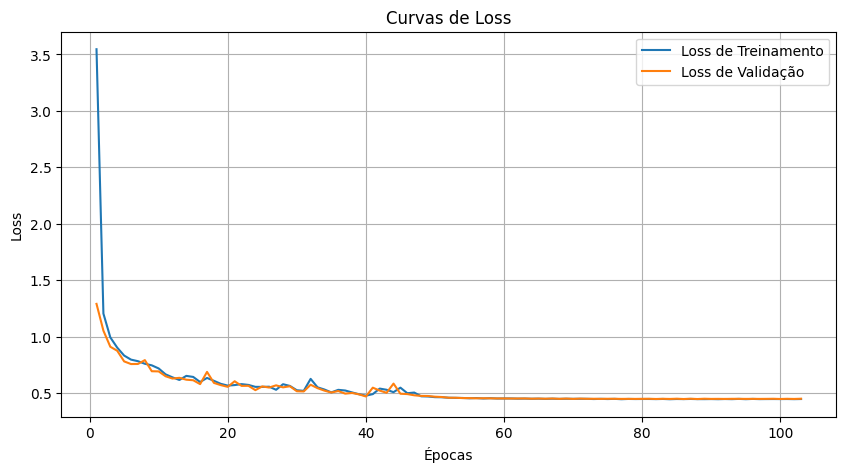

Model saved at 'models/teste_BOTH/teste1/BOTH.pth'

--- Training model: BOTH - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6472, Validation Loss: 0.5909
Epoch [2/500], Train Loss: 0.5446, Validation Loss: 0.5003
Epoch [3/500], Train Loss: 0.4798, Validation Loss: 0.4617
Epoch [4/500], Train Loss: 0.4498, Validation Loss: 0.4377
Epoch [5/500], Train Loss: 0.4288, Validation Loss: 0.4205
Epoch [6/500], Train Loss: 0.4108, Validation Loss: 0.4041
Epoch [7/500], Train Loss: 0.3953, Validation Loss: 0.3922
Epoch [8/500], Train Loss: 0.3834, Validation Loss: 0.3799
Epoch [9/500], Train Loss: 0.3727, Validation Loss: 0.3708
Epoch [10/500], Train Loss: 0.3627, Validation Loss: 0.3617
Epoch [11/500], Train Loss: 0.3551, Validation Loss: 0.3546
Epoch [12/500], Train Loss: 0.3475, Validation Loss: 0.3490
Epoch [13/500], Train Loss: 0.3414, Validation Loss: 0.3449
Epoch [14/500], Train Loss: 0.3372, Validation Loss: 0.3380
Epoch [15/500], Train Loss: 0.3316, Validation Loss: 0.

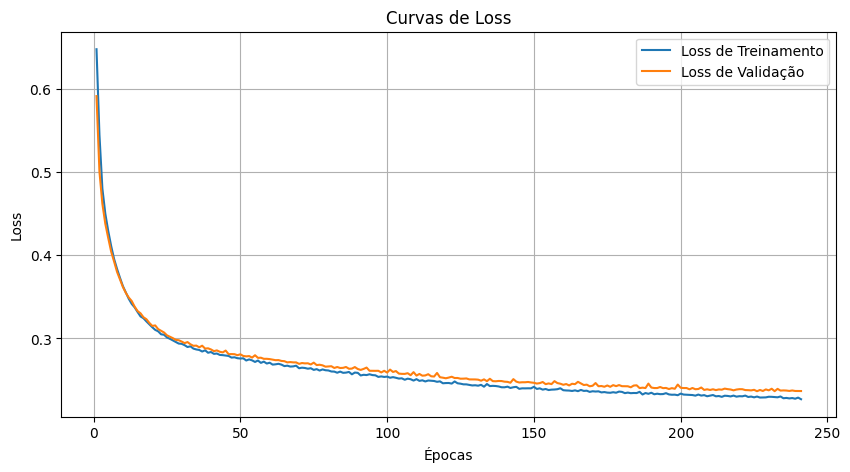

Model saved at 'models/teste_BOTH/teste2/BOTH.pth'

--- Training model: BOTH - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 2.8520, Validation Loss: 0.6049
Epoch [2/500], Train Loss: 0.5595, Validation Loss: 0.4734
Epoch [3/500], Train Loss: 0.5158, Validation Loss: 0.4193
Epoch [4/500], Train Loss: 0.4220, Validation Loss: 0.3828
Epoch [5/500], Train Loss: 0.4022, Validation Loss: 0.4066
Epoch [6/500], Train Loss: 0.3933, Validation Loss: 0.4052
Epoch [7/500], Train Loss: 0.3965, Validation Loss: 0.3856
Epoch [8/500], Train Loss: 0.3725, Validation Loss: 0.4168
Epoch [9/500], Train Loss: 0.3529, Validation Loss: 0.3719
Epoch [10/500], Train Loss: 0.3659, Validation Loss: 0.3284
Epoch [11/500], Train Loss: 0.3147, Validation Loss: 0.2772
Epoch [12/500], Train Loss: 0.2846, Validation Loss: 0.2544
Epoch [13/500], Train Loss: 0.2922, Validation Loss: 0.3543
Epoch [14/500], Train Loss: 0.3238, Validation Loss: 0.2613
Epoch [15/500], Train Loss: 0.2908, Validation Loss: 0.

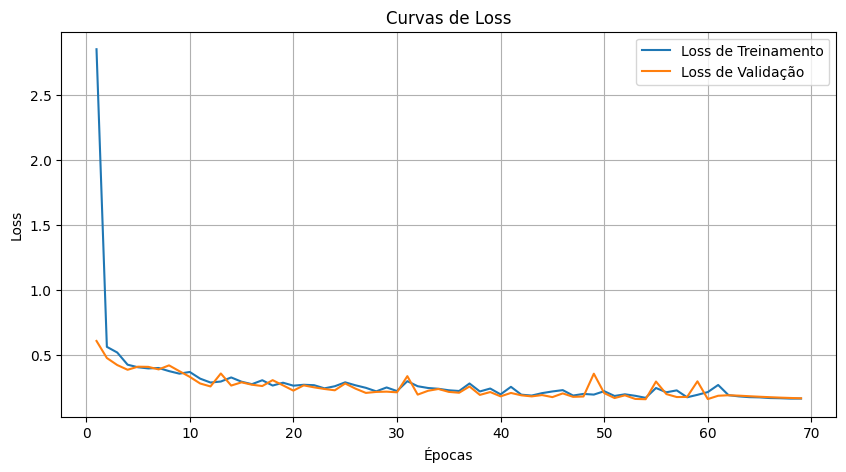

Model saved at 'models/teste_BOTH/teste3/BOTH.pth'



In [116]:
epochs = 500

for test in test_ids:
    model = IDSBranchyNet()
    
    if test == 1:
        weight1 = 1
        weight2 = 1
    elif test == 2:
        weight1 = 1
        weight2 = 0
    elif test == 3:
        weight1 = 0
        weight2 = 1
        
    
        
    print(f"--- Training model: {modelname} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
    train_losses, val_losses = train_model(model, train_loaders, val_loaders, epochs, weight1, weight2, lr=0.01, device=device, modelname=modelname, test=test)

    torch.save(model.state_dict(), f'models/teste_BOTH/teste{test}/{modelname}.pth')
    print(f"Model saved at 'models/teste_BOTH/teste{test}/{modelname}.pth'\n")
    

--- Model: BOTH | Loader: UNSW | TestID: 1 | Threshold: 0.6 ---
Model from: 'models/teste_BOTH/teste1/BOTH.pth' carregado


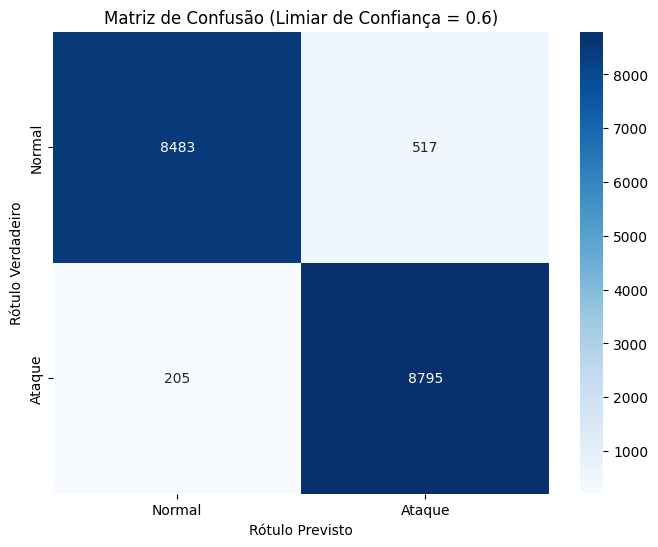

True Positives (TP): 8795
True Negatives (TN): 8483
False Positives (FP): 517
False Negatives (FN): 205

F1 Score: 0.9606
True Positive Rate (TPR) / Recall: 0.9772
True Negative Rate (TNR) / Specificity: 0.9426
--------------------
Threshold: 0.6
  Accuracy: 95.99%
  Avg. Inference Time: 0.0027 ms
  Early Exit Rate: 94.56% (17020/18000)
--------------------


--- Model: BOTH | Loader: UNSW | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste_BOTH/teste2/BOTH.pth' carregado


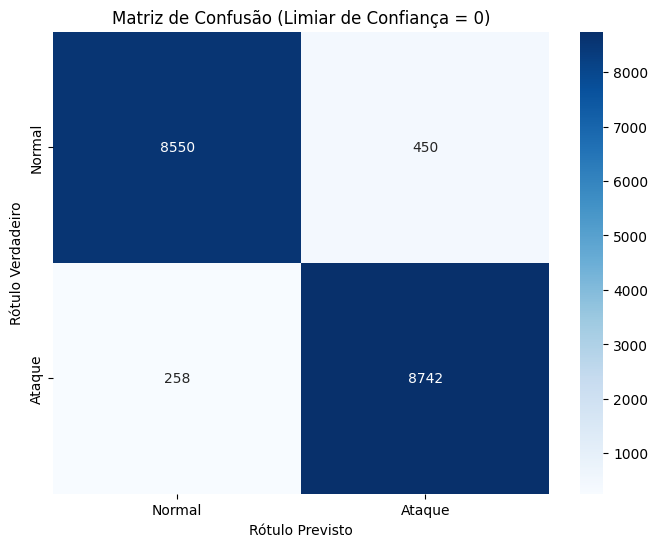

True Positives (TP): 8742
True Negatives (TN): 8550
False Positives (FP): 450
False Negatives (FN): 258

F1 Score: 0.9611
True Positive Rate (TPR) / Recall: 0.9713
True Negative Rate (TNR) / Specificity: 0.9500
--------------------
Threshold: 0
  Accuracy: 96.07%
  Avg. Inference Time: 0.0014 ms
  Early Exit Rate: 100.00% (18000/18000)
--------------------


--- Model: BOTH | Loader: UNSW | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste_BOTH/teste3/BOTH.pth' carregado


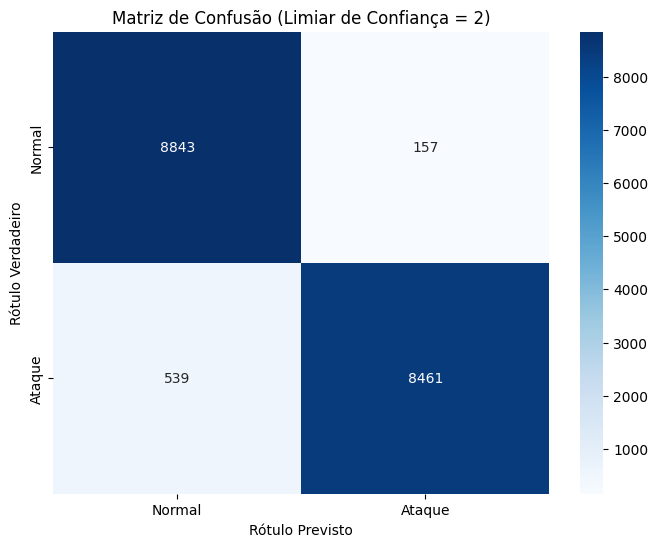

True Positives (TP): 8461
True Negatives (TN): 8843
False Positives (FP): 157
False Negatives (FN): 539

F1 Score: 0.9605
True Positive Rate (TPR) / Recall: 0.9401
True Negative Rate (TNR) / Specificity: 0.9826
--------------------
Threshold: 2
  Accuracy: 96.13%
  Avg. Inference Time: 0.0038 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 1 | Threshold: 0.6 ---
Model from: 'models/teste_BOTH/teste1/BOTH.pth' carregado


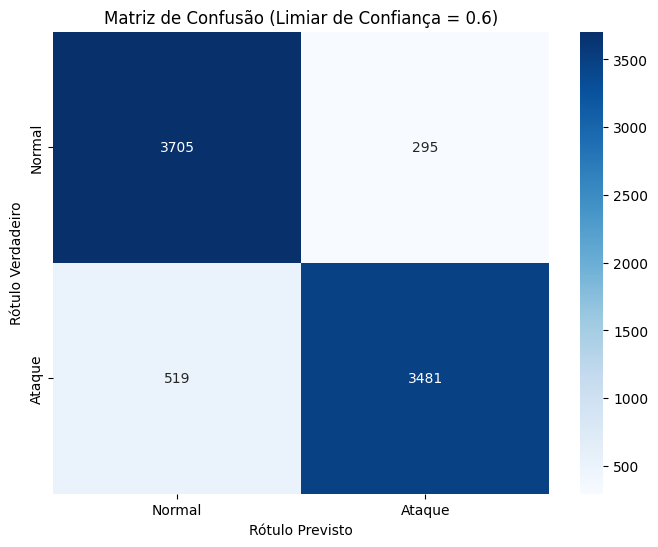

True Positives (TP): 3481
True Negatives (TN): 3705
False Positives (FP): 295
False Negatives (FN): 519

F1 Score: 0.8953
True Positive Rate (TPR) / Recall: 0.8702
True Negative Rate (TNR) / Specificity: 0.9263
--------------------
Threshold: 0.6
  Accuracy: 89.83%
  Avg. Inference Time: 0.0028 ms
  Early Exit Rate: 77.80% (6224/8000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste_BOTH/teste2/BOTH.pth' carregado


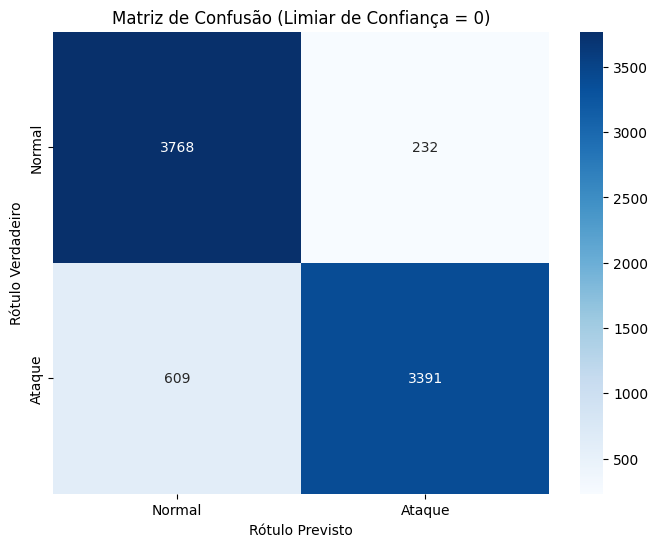

True Positives (TP): 3391
True Negatives (TN): 3768
False Positives (FP): 232
False Negatives (FN): 609

F1 Score: 0.8897
True Positive Rate (TPR) / Recall: 0.8478
True Negative Rate (TNR) / Specificity: 0.9420
--------------------
Threshold: 0
  Accuracy: 89.49%
  Avg. Inference Time: 0.0014 ms
  Early Exit Rate: 100.00% (8000/8000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste_BOTH/teste3/BOTH.pth' carregado


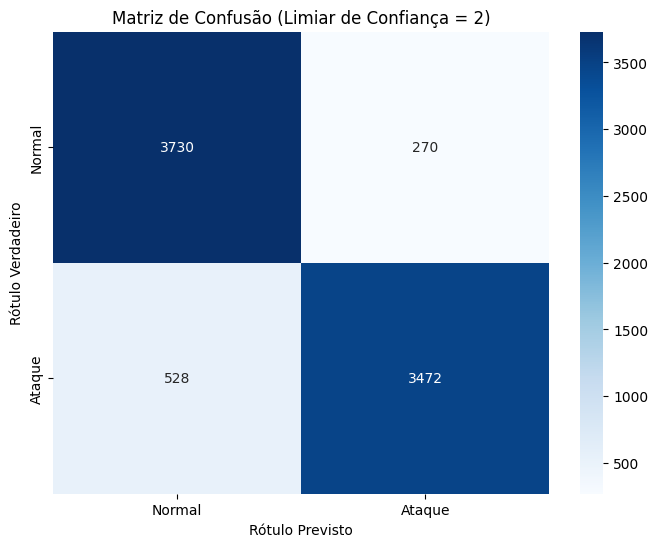

True Positives (TP): 3472
True Negatives (TN): 3730
False Positives (FP): 270
False Negatives (FN): 528

F1 Score: 0.8969
True Positive Rate (TPR) / Recall: 0.8680
True Negative Rate (TNR) / Specificity: 0.9325
--------------------
Threshold: 2
  Accuracy: 90.03%
  Avg. Inference Time: 0.0042 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 1 | Threshold: 0.6 ---
Model from: 'models/teste_BOTH/teste1/BOTH.pth' carregado


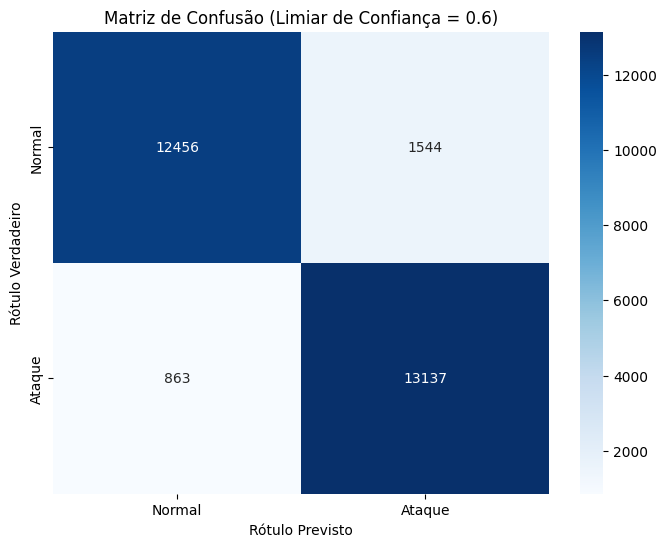

True Positives (TP): 13137
True Negatives (TN): 12456
False Positives (FP): 1544
False Negatives (FN): 863

F1 Score: 0.9161
True Positive Rate (TPR) / Recall: 0.9384
True Negative Rate (TNR) / Specificity: 0.8897
--------------------
Threshold: 0.6
  Accuracy: 91.40%
  Avg. Inference Time: 0.0028 ms
  Early Exit Rate: 91.64% (25659/28000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste_BOTH/teste2/BOTH.pth' carregado


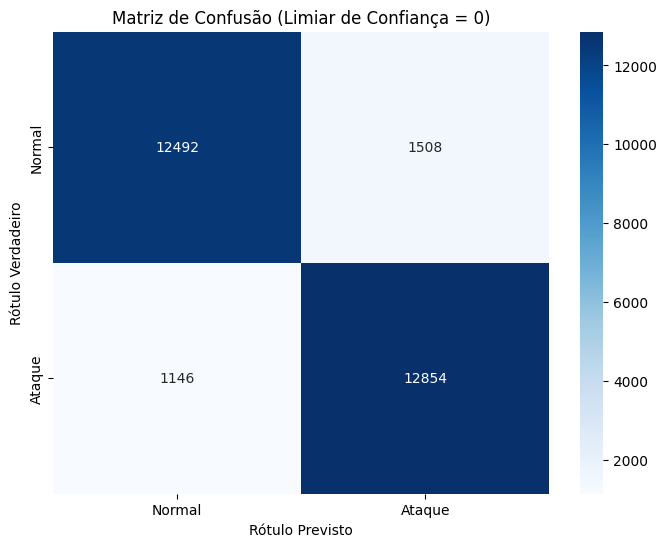

True Positives (TP): 12854
True Negatives (TN): 12492
False Positives (FP): 1508
False Negatives (FN): 1146

F1 Score: 0.9064
True Positive Rate (TPR) / Recall: 0.9181
True Negative Rate (TNR) / Specificity: 0.8923
--------------------
Threshold: 0
  Accuracy: 90.52%
  Avg. Inference Time: 0.0011 ms
  Early Exit Rate: 100.00% (28000/28000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste_BOTH/teste3/BOTH.pth' carregado


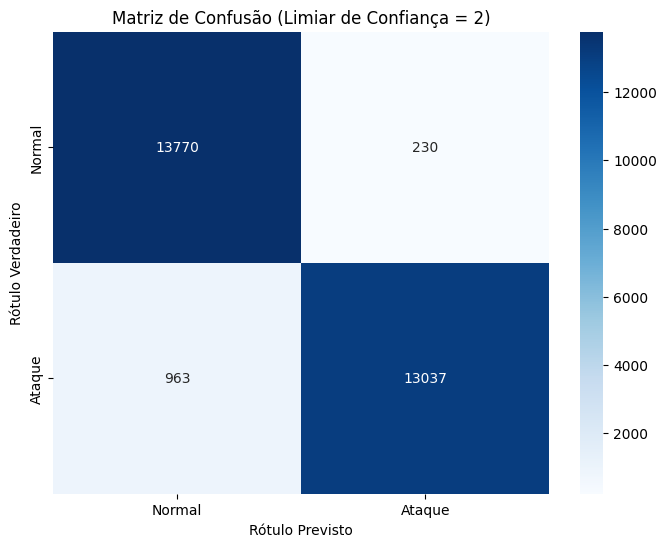

True Positives (TP): 13037
True Negatives (TN): 13770
False Positives (FP): 230
False Negatives (FN): 963

F1 Score: 0.9562
True Positive Rate (TPR) / Recall: 0.9312
True Negative Rate (TNR) / Specificity: 0.9836
--------------------
Threshold: 2
  Accuracy: 95.74%
  Avg. Inference Time: 0.0032 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------




In [117]:
for loader in range(len(test_loaders)):
    for test in test_ids:
        if test == 1:
            T = 0.6
        elif test == 2:
            T = 0
        elif test == 3:
            T = 2

        print(f"--- Model: {modelname} | Loader: {loader_names[loader]} | TestID: {test} | Threshold: {T} ---")

        model.load_state_dict(torch.load(f'models/teste_BOTH/teste{test}/{modelname}.pth'))
        print(f"Model from: 'models/teste_BOTH/teste{test}/{modelname}.pth' carregado")

        results = evaluate_model(model, test_loaders[loader], confidence_threshold=T, device=device)
        print("-" * 20)
        print(f"Threshold: {T}")
        print(f"  Accuracy: {results['accuracy']:.2f}%")
        print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
        print(f"  Early Exit Rate: {results['exit_rate']:.2f}% ({results['exited_early_count']}/{results['total_samples']})")
        print("-" * 20)
        print("\n")